# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/aivle/6차 미니프로젝트/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/MyDrive/project/'

#### 3) 데이터 읽어오기

In [ ]:
import os

In [ ]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [ ]:
data = pd.read_csv(os.path.join(path, file1))

In [ ]:
weather = pd.read_csv(os.path.join(path, file2))

#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [ ]:
data.info()

In [ ]:
weather.info()

#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [ ]:
data.columns = ['Date', 'Drive', 'Reservation', 'Ride', 'Avg_wait', 'Avg_tax', 'Avg_distance']
data.head(3)

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [ ]:
df = data.copy()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2922 non-null   datetime64[ns]
 1   Drive         2922 non-null   int64         
 2   Reservation   2922 non-null   int64         
 3   Ride          2922 non-null   int64         
 4   Avg_wait      2922 non-null   float64       
 5   Avg_tax       2922 non-null   int64         
 6   Avg_distance  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


In [ ]:
df['Day'] = df['Date'].dt.strftime('%A')
df['Week'] = df['Date'].dt.week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head(3)

<ipython-input-25-fc69fa499692>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Date'].dt.week


,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,Day,Week,Month,Year
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,2015


### (2) 일별

* 차량 운행수

In [ ]:
df.set_index('Date', inplace = True)
df.resample('D').size()

Date
2015-01-01    1
2015-01-02    1
2015-01-03    1
2015-01-04    1
2015-01-05    1
             ..
2022-12-27    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
2022-12-31    1
Freq: D, Length: 2922, dtype: int64

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (3) 요일별

* 차량 운행수

<Axes: xlabel='Day', ylabel='Drive'>

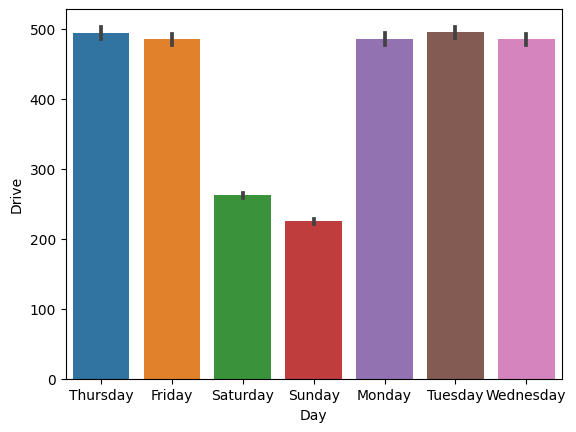

In [ ]:
sns.barplot(x = 'Day', y = 'Drive', data = df)

<Axes: xlabel='Day', ylabel='Drive'>

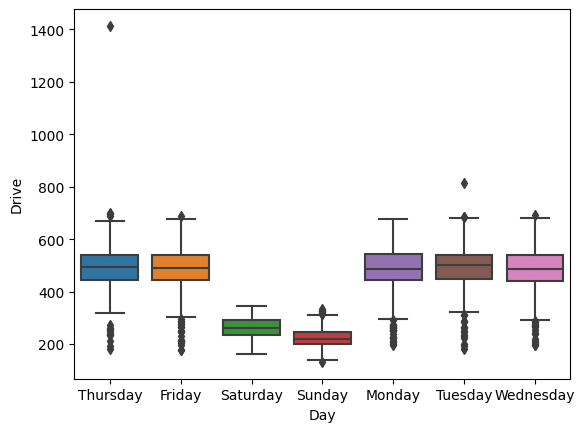

In [ ]:
sns.boxplot(x = 'Day', y = 'Drive', data = df)

* 접수건, 탑승건

<Axes: xlabel='Day', ylabel='Reservation'>

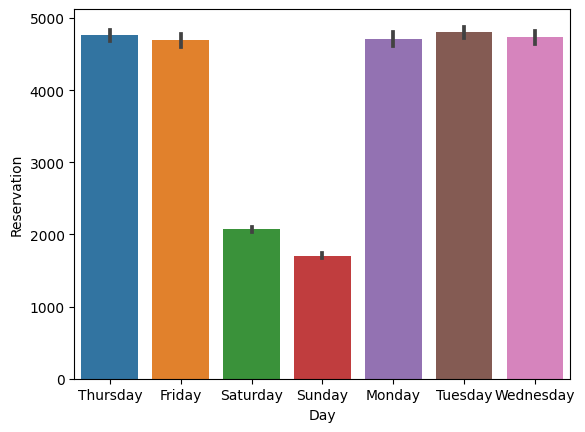

In [ ]:
sns.barplot(x = 'Day', y = 'Reservation', data = df)

<Axes: xlabel='Day', ylabel='Ride'>

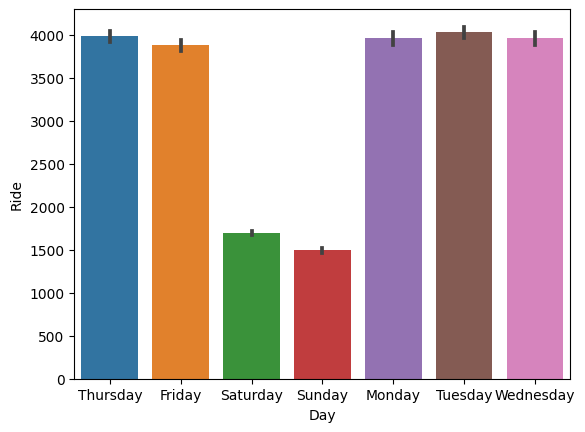

In [ ]:
sns.barplot(x = 'Day', y = 'Ride', data = df)

* 대기시간

<Axes: xlabel='Day', ylabel='Avg_wait'>

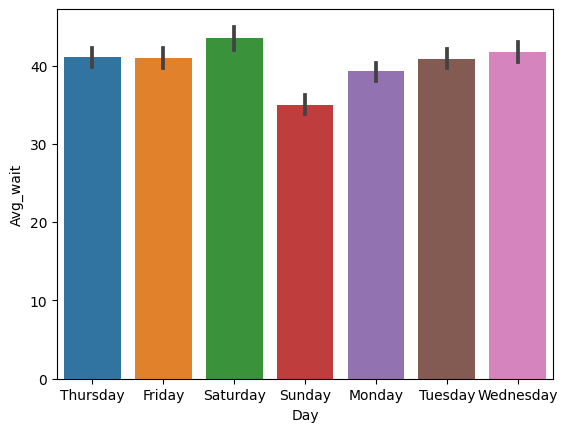

In [ ]:
sns.barplot(x = 'Day', y = 'Avg_wait', data = df)

* 운임

<Axes: xlabel='Day', ylabel='Avg_tax'>

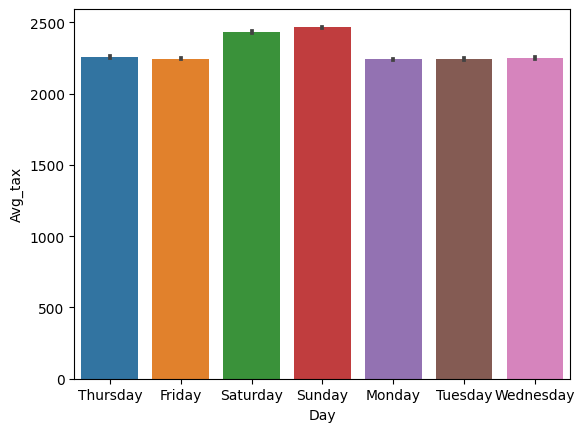

In [ ]:
sns.barplot(x = 'Day', y = 'Avg_tax', data = df)

* 이동거리

<Axes: xlabel='Day', ylabel='Avg_distance'>

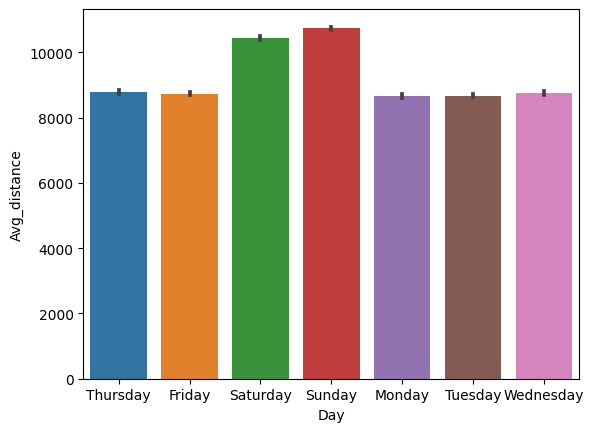

In [ ]:
sns.barplot(x = 'Day', y = 'Avg_distance', data = df)

### (4) 월별

* 차량 운행수

<Axes: xlabel='Month', ylabel='Drive'>

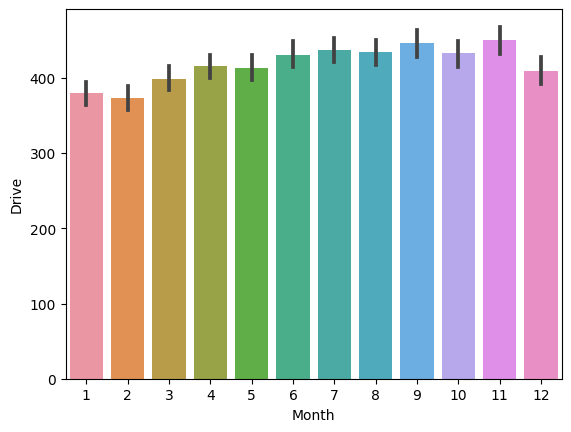

In [ ]:
sns.barplot(x = 'Month', y = 'Drive', data = df)

* 접수건, 탑승건

<Axes: xlabel='Month', ylabel='Reservation'>

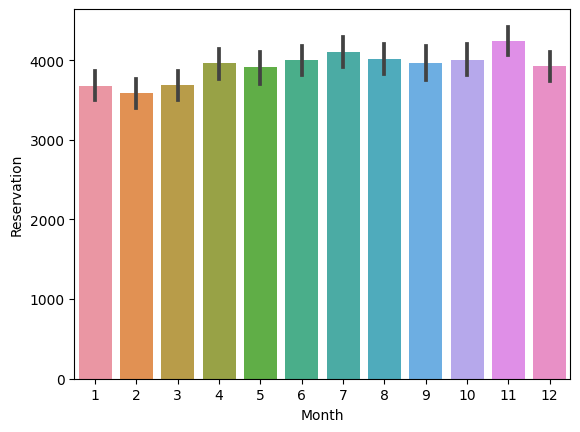

In [ ]:
sns.barplot(x = 'Month', y = 'Reservation', data = df)

<Axes: xlabel='Month', ylabel='Ride'>

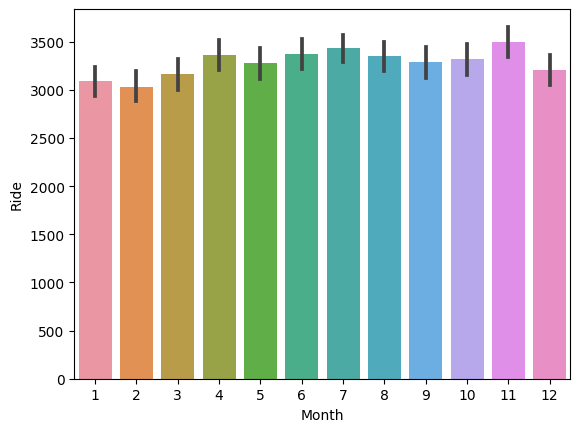

In [ ]:
sns.barplot(x = 'Month', y = 'Ride', data = df)

* 대기시간

<Axes: xlabel='Month', ylabel='Avg_wait'>

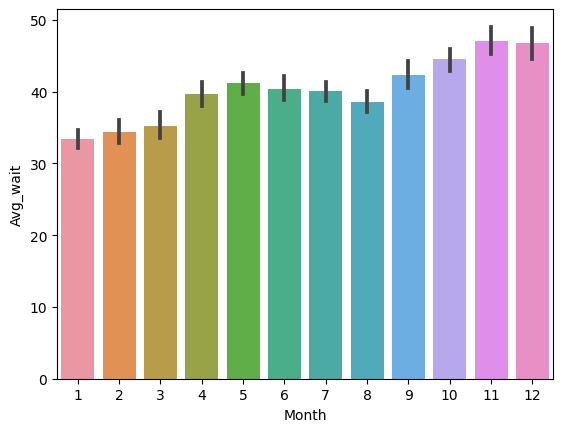

In [ ]:
sns.barplot(x = 'Month', y = 'Avg_wait', data = df)

* 운임

<Axes: xlabel='Month', ylabel='Avg_tax'>

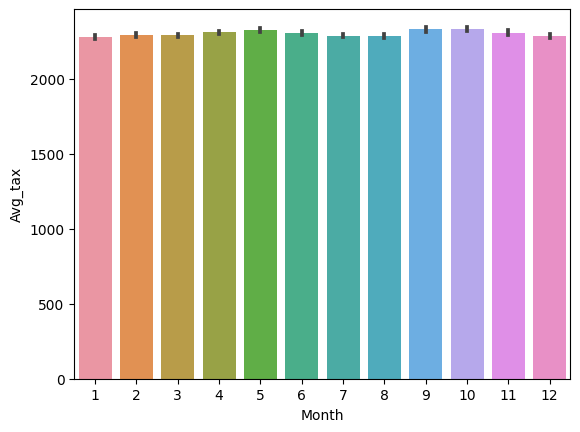

In [ ]:
sns.barplot(x = 'Month', y = 'Avg_tax', data = df)

* 이동거리

<Axes: xlabel='Month', ylabel='Avg_distance'>

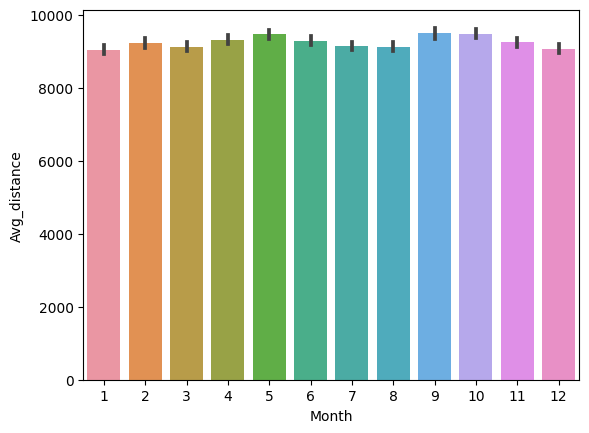

In [ ]:
sns.barplot(x = 'Month', y = 'Avg_distance', data = df)

### (5) 연도별

* 차량 운행수

<Axes: xlabel='Year', ylabel='Drive'>

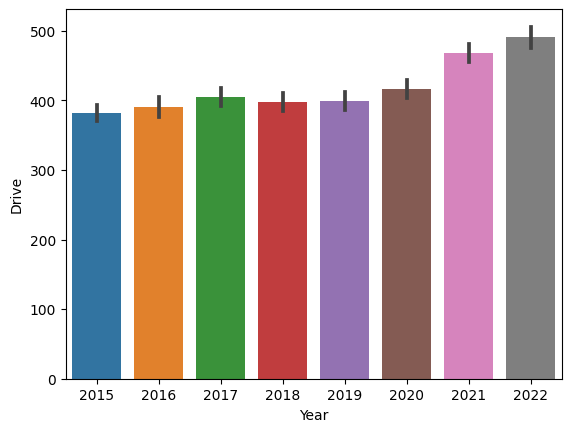

In [ ]:
sns.barplot(x = 'Year', y = 'Drive', data = df)

* 대기시간

<Axes: xlabel='Year', ylabel='Avg_wait'>

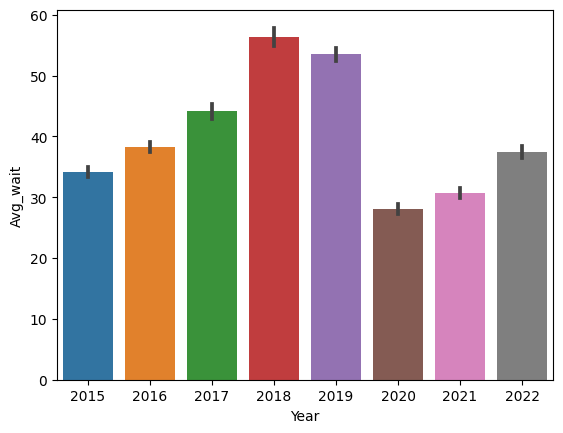

In [ ]:
sns.barplot(x = 'Year', y = 'Avg_wait', data = df)

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [ ]:
merge_df.tail(10)

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [ ]:
merge_df['target'] = merge_df['Avg_wait']

In [ ]:
merge_df.isna().sum()

Date               0
Drive              0
Reservation        0
Ride               0
Avg_wait           0
Avg_tax            0
Avg_distance       0
temp_max           1
temp_min           1
rain(mm)           1
humidity_max(%)    1
humidity_min(%)    1
sunshine(MJ/m2)    1
Avg_wait_mean      6
Ride_ratio         0
Holiday            0
Day                0
Month              0
Season             0
Year               0
target             0
dtype: int64

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [ ]:
exclude_col = 'Date'
shift_col = weather.columns.difference([exclude_col])
weather[shift_col] = weather[shift_col].shift(-1)
weather

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
1,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
2,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
3,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
4,2012-01-05,1.3,-4.8,0.0,55.0,27.0,8.57
...,...,...,...,...,...,...,...
4013,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
4014,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
4015,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84
4016,2022-12-30,-4.4,-4.4,0.0,66.0,66.0,0.00


In [ ]:
weather['Date'] = pd.to_datetime(weather['Date'])
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
merge_df =  pd.merge(data, weather, how = 'left')
merge_df

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86
2918,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84
2920,2022-12-30,600,5293,4200,38.3,2183,8155,-4.4,-4.4,0.0,66.0,66.0,0.00


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [ ]:
merge_df['Date'] = pd.to_datetime(merge_df['Date'])

merge_df['Day'] = merge_df['Date'].dt.day_name()
merge_df['Month'] = merge_df['Date'].dt.month_name()
merge_df['Season'] = pd.cut(merge_df['Date'].dt.month, bins = [0, 3, 6, 9, 12], labels = ['Winter', 'Spring', 'Summer', 'Fall'])
merge_df['Year'] = merge_df['Date'].dt.year

merge_df['Day'] = pd.Categorical(merge_df['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
# merge_df['Month'] = pd.Categorical(merge_df['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered= True)
merge_df['Season'] = pd.Categorical(merge_df['Season'], categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered= True)

merge_df

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),Avg_wait_mean,Ride_ratio,Holiday,Day,Month,Season,Year
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,NaN,0.903226,New year,Thursday,January,Winter,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,NaN,0.898987,0,Friday,January,Winter,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,NaN,0.918689,0,Saturday,January,Winter,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,NaN,0.927096,0,Sunday,January,Winter,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,NaN,0.877647,0,Monday,January,Winter,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,42.771429,0.825909,0,Tuesday,December,Fall,2022
2919,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,43.514286,0.822073,0,Wednesday,December,Fall,2022
2920,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,42.957143,0.808952,0,Thursday,December,Fall,2022
2921,2022-12-30,600,5293,4200,38.3,2183,8155,-4.4,-4.4,0.0,66.0,66.0,0.00,41.042857,0.793501,0,Friday,December,Fall,2022


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [ ]:
!pip install workalendar

* 간단 사용법

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [ ]:
holiday_df = pd.DataFrame(columns = ['date', 'holiday'])

for year in range(2015, 2023):
    temp = pd.DataFrame(cal.holidays(year))
    holiday_df = pd.concat([holiday_df, temp], axis = 0)

holiday_df.drop(['date', 'holiday'], axis = 1, inplace = True)
holiday_df.columns = ['Date', 'Holiday']

holiday_df

,Date,Holiday
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
...,...,...
10,2022-09-10,Midautumn Festival
11,2022-09-11,Midautumn Festival
12,2022-10-03,National Foundation Day
13,2022-10-09,Hangul Day


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [ ]:
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
merge_df = pd.merge(merge_df, holiday_df, how = 'left')

In [ ]:
merge_df['Holiday'].fillna('0', inplace = True)
merge_df

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),Avg_wait_mean,Ride_ratio,Holiday
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,NaN,0.903226,New year
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,NaN,0.898987,0
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,NaN,0.918689,0
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,NaN,0.927096,0
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,NaN,0.877647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,42.771429,0.825909,0
2919,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,43.514286,0.822073,0
2920,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,42.957143,0.808952,0
2921,2022-12-30,600,5293,4200,38.3,2183,8155,-4.4,-4.4,0.0,66.0,66.0,0.00,41.042857,0.793501,0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [ ]:
merge_df['Avg_wait_mean'] = df['Avg_wait'].rolling(7).mean()
merge_df.tail(10)

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),Avg_wait_mean
2912,2022-12-22,625,5899,4716,56.4,2188,8051,-9.2,-13.7,0.0,65.0,53.0,10.76,45.242857
2913,2022-12-23,607,5570,4361,51.7,2159,8003,-2.1,-13.5,0.0,69.0,40.0,10.92,46.257143
2914,2022-12-24,308,2279,1910,29.4,2367,9806,-0.2,-9.5,0.0,81.0,47.0,10.89,43.614286
2915,2022-12-25,217,1945,1588,38.7,2416,10212,1.5,-7.9,0.0,85.0,46.0,8.27,45.114286
2916,2022-12-26,603,5555,4605,39.2,2163,7889,3.0,-7.3,0.0,86.0,51.0,10.25,43.485714
2917,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,42.771429
2918,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,43.514286
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,42.957143
2920,2022-12-30,600,5293,4200,38.3,2183,8155,-4.4,-4.4,0.0,66.0,66.0,0.00,41.042857
2921,2022-12-31,263,2167,1806,33.7,2318,9435,NaN,NaN,NaN,NaN,NaN,NaN,41.657143


#### 4) 탑승률

In [ ]:
merge_df['Ride_ratio'] = merge_df['Ride'] / merge_df['Reservation']
merge_df.head(10)

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),Avg_wait_mean,Ride_ratio
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,NaN,0.903226
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,NaN,0.898987
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,NaN,0.918689
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,NaN,0.927096
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,NaN,0.877647
5,2015-01-06,417,3991,3633,23.6,2211,8545,-1.0,-8.8,0.0,42.0,24.0,10.12,NaN,0.910298
6,2015-01-07,410,4085,3676,24.7,2230,8646,-0.2,-9.2,0.0,62.0,27.0,10.09,23.657143,0.899878
7,2015-01-08,419,4030,3728,21.2,2231,8683,3.2,-6.8,0.0,78.0,38.0,8.74,23.371429,0.925062
8,2015-01-09,424,4167,3813,21.8,2215,8506,4.3,-5.5,0.0,81.0,33.0,9.41,24.028571,0.915047
9,2015-01-10,215,1916,1645,41.2,2447,11123,2.3,-4.0,0.0,83.0,39.0,9.60,26.171429,0.858559


## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [ ]:
joblib.dump(merge_df, os.path.join(path, 'data1.pkl'))

['/content/drive/MyDrive/aivle/6차 미니프로젝트/data1.pkl']

In [ ]:
joblib.dump(merge_df, 'data1.pkl')
/content/data1.pkl

['data1.pkl']

In [ ]:
merge_df

,Date,Drive,Reservation,Ride,Avg_wait,Avg_tax,Avg_distance,temp_max,temp_min,rain(mm),...,humidity_min(%),sunshine(MJ/m2),Avg_wait_mean,Ride_ratio,Holiday,Day,Month,Season,Year,target
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,...,28.0,9.07,NaN,0.903226,New year,Thursday,January,Winter,2015,23.2
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,...,37.0,8.66,NaN,0.898987,0,Friday,January,Winter,2015,17.2
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,...,58.0,5.32,NaN,0.918689,0,Saturday,January,Winter,2015,26.2
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,...,52.0,6.48,NaN,0.927096,0,Sunday,January,Winter,2015,24.5
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,...,29.0,10.47,NaN,0.877647,0,Monday,January,Winter,2015,26.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,...,40.0,10.86,42.771429,0.825909,0,Tuesday,December,Fall,2022,44.4
2919,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,...,34.0,10.88,43.514286,0.822073,0,Wednesday,December,Fall,2022,44.8
2920,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,...,38.0,10.84,42.957143,0.808952,0,Thursday,December,Fall,2022,52.5
2921,2022-12-30,600,5293,4200,38.3,2183,8155,-4.4,-4.4,0.0,...,66.0,0.00,41.042857,0.793501,0,Friday,December,Fall,2022,38.3
